# LENDING CLUB 

## Data Engineering & EDA

En este notebook se van a analizar pormenorizadamente cada una de las variables del data set del conjunto de toda la muestra.

Este proceso consta de estas etapas:
-	Importación de librerías: Importación de las diferentes librerías necesarias.
-	Importación de los datos: Importación de los datos del conjunto de la muestra que se han unido en el notebook1
    -	Estudio de Variables:
        -	Target: se define la variable objetivo a predecir en este modelo.
        -	Variables que omitimos por su contenido. Se trata de variables que por su definición o por su disposición en el momento en el que llega el cliente no disponemos.
        -	Variables con alto % de NAs. Se eliminan aquellas variables que en la mayoría de observaciones su valor es NA.
        -	Variables con valores nulos por razones alternativas. Algunas variables contienen valores nulos debido a la inexistencia del tipo de cuenta del que trata la variable o bien, porque el cliente nunca ha realizado la acción estipulada en la variable.
    -	VARIABLES NUMÉRICAS:
        -	Detección de Outliers
        -	Sustitución de los valores nulos por la mediana 
        -	Estudio de la distribución de las variables numéricas (histogramas) Normalización de las variables numéricas.
    -	VARIABLES CATEGÓRICAS:
        -	Sustitución de los valores nulos por la moda
        -	Variables que no se pueden utilizar para predecir el impago
        -	Variables con excesivo número de clases
        -	Variables con clases desbalanceadas
        -	Variables categóricas erróneas
        -	Reducción del número de categorías
        -	Edición de la variable "grade"
        -	E studio de la relevancia de los grupos
        -	Gráficos de Frecuencias.
        -	Variables Dummies


In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing 

## IMPORTACIÓN DE LOS  DATOS

In [2]:
path = ('../data/02_intermediate/loan_all.csv') # aqui introducimos el dataset en cuestión
data = pd.read_csv(path, low_memory=False) # Lo_memory = False es para evitar el warning por
# ser columnas de distinto formato

In [3]:
data.head(3)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,112435993,NaN,2300,2300,2300.0,36 months,12.62%,77.08,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,112290210,NaN,16000,16000,16000.0,60 months,12.62%,360.95,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,112436985,NaN,6025,6025,6025.0,36 months,15.05%,209.01,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Eliminamos la columna de índice 'Unnamed: 0', que se crea por defecto

In [4]:
# Como hemos creado el data frame con python exporta el csv añadiendo la columna del índice
# OJO, si cambiamos el orgien de los datos es posible que haya que eliminarlo!

del data['Unnamed: 0']

In [5]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,112435993,NaN,2300,2300,2300.0,36 months,12.62%,77.08,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,112290210,NaN,16000,16000,16000.0,60 months,12.62%,360.95,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,112436985,NaN,6025,6025,6025.0,36 months,15.05%,209.01,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## ESTUDIO DE VARIABLES:

### Variable Target:

La variable objetivo del estudio que se quiere predecir es el pago o impago de los préstamos. En el data set original esta información la proporciona la variable: "loan_status".

En primer lugar se analiza cual es la frecuencia de cada uno de los posibles estados del préstamo:

In [6]:
data['loan_status'].value_counts(dropna=False)

Current               422685
Fully Paid            345520
Charged Off            97047
Late (31-120 days)     11168
In Grace Period         5507
Late (16-30 days)       2915
Default                   34
Name: loan_status, dtype: int64

El objetivo será predecir aquellos clientes que van a pagar el préstamnos íntegramente y aquellos que no lo van a hacer.

Para ello, en función de los valores de la variable "loan_status", se definen  dos grupos:
    
  __GRUPO 1__

Clientes que han pagado el préstamo íntegramente, cuyo 'loan_status' sería:

- Fully Paid.


 __GRUPO 2__

Clientes que no han pagado el préstamo, cuyo 'loan_status' sería:

- Charged Off: Después de que un préstamo ha sido incumplido, la entidad toma medidas. Una vez estas  acciones y las de las agencias de cobro de deudas se completan, el préstamo es "cargado". A partir de este estado todos saben que no se toman más medidas sobre este préstamo y todas las reclamaciones, cobros y medidas legales que son posibles han sido completadas.

- Default: cuando un préstamo tiene uno o más pagos atrasados por más de 90 días, el préstamo se considera como "impago".

- In Grace Period: Este estado indica que un préstamo ha vencido (independientemente de si es el primer pago o un pago consecutivo del préstamo). Este período dura 3 días desde el momento en que el pago se vence. Si el prestatario completa el pago durante ese tiempo, el pago se marca como "Pagado a tiempo" y no se cobran intereses de demora en el préstamo.

- Late (16-30 days): cuando uno o más pagos de un préstamo se atrasan más de 16 días, pero menos de 31 días. Este es el primero de los dos rangos de retraso. Esto también significa que hemos empezado a ponernos en contacto con el prestatario a través de múltiples canales de comunicación para recordarle sus obligaciones de pago.

- Late (31-120 days): cuando uno o más pagos de un préstamo están atrasados por 31 días o más, pero menos de 120 días. Cuando un préstamo se encuentra en este estado, los procedimientos de reclamación están en curso y regularmente nos ponemos en contacto con el prestatario por correo electrónico y por teléfono.

__EXCLUDED VALUE__

Hay incertidumbre en el siguiente estado :

- Current: un préstamo puede tener el estado "Current" cuando se han completado uno o más pagos y no hay ningún pago atrasado. También significa que este préstamo todavía tiene uno o más pagos futuros programados.

Por las caraterísticas de este estado y del modelo que se quiere establecer, es procedente eliminar los registros con este tipo de estado de nuestro data set.

In [9]:
# Eliminamos las observaciones cuyo status es "Current"
data = data.drop(data[data['loan_status']=="Current"].index)

In [10]:
# Visualizamos el número de observaciones que hay para cada posible status
data['loan_status'].value_counts(dropna=False)

Fully Paid            345520
Charged Off            97047
Late (31-120 days)     11168
In Grace Period         5507
Late (16-30 days)       2915
Default                   34
Name: loan_status, dtype: int64

In [12]:
# Creamos columna llamada target
# toma valor 0 si fully paid y valor 1 en caso contrario (impago)
data['target'] = np.where((data['loan_status'] == 'Fully Paid'), 0, 1)

Observamos que hay 345520 observaciones que han pagado y 116671 con impago

In [13]:
data['target'].value_counts(dropna=False)

0    345520
1    116671
Name: target, dtype: int64

In [14]:
# Se crea un dataframe para poder obtener el porcentaje de impago
porcentaje = pd.DataFrame(data['target'].value_counts(dropna=False))

Se calcula el porcentaje de impago de las observaciones y obtenemos que el 25.24% de los préstamos tienen impago

In [15]:
# Cálculo del porcentaje de impago
porcentaje.iloc[1]/(porcentaje.iloc[1] + porcentaje.iloc[0])

target    0.25243
dtype: float64

In [16]:
# Eliminamos la columna de loan_status y dejamos solo la columna de Target
del data['loan_status']

In [17]:
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target
8,112038251,NaN,11575,11575,11575.0,36 months,7.35%,359.26,A,A4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
10,112149045,NaN,7200,7200,7200.0,36 months,24.85%,285.70,E,E3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
24,112052261,NaN,7500,7500,7500.0,36 months,7.35%,232.79,A,A4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
42,111999259,NaN,10000,10000,10000.0,60 months,16.02%,243.29,C,C5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
91,111808508,NaN,14000,14000,14000.0,36 months,16.02%,492.34,C,C5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


### Variables que omitimos por su contenido:

Eliminamos las variables que aportan información similar a la variable target:




In [19]:
del data['out_prncp_inv']
del data['total_pymnt']
del data['out_prncp']
del data['total_pymnt_inv']
del data['total_rec_prncp']
del data['recoveries']
del data['hardship_flag']
del data['debt_settlement_flag']
del data['settlement_date']
del data['settlement_status']
del data['settlement_amount']
del data['settlement_percentage']
del data['settlement_term']
del data['emp_title']
del data['issue_d']
del data['last_credit_pull_d']
del data['last_pymnt_d']
del data['total_rec_int']
del data['total_rec_late_fee']
del data['last_pymnt_amnt']
del data['pymnt_plan']
del data['next_pymnt_d']

Ahora tenemos 129 variables

In [20]:
data.shape 

(462191, 129)

### Variables con alto % de NA

Primero obtenemos el porcentaje de valores nulos de cada columna

In [21]:
percentage_NaN = data.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(40)

member_id                                     1.000000
sec_app_mths_since_last_major_derog           0.998771
orig_projected_additional_accrued_interest    0.997986
hardship_type                                 0.997174
hardship_end_date                             0.997174
hardship_reason                               0.997174
hardship_status                               0.997174
deferral_term                                 0.997174
hardship_amount                               0.997174
hardship_start_date                           0.997174
payment_plan_start_date                       0.997174
hardship_length                               0.997174
hardship_dpd                                  0.997174
hardship_loan_status                          0.997174
hardship_payoff_balance_amount                0.997174
hardship_last_payment_amount                  0.997174
sec_app_revol_util                            0.997036
sec_app_open_acc                              0.996962
sec_app_fi

A continuación creamos un dataframe con los porcentajes de valores nulos de todo el dataset

In [22]:
NaN = pd.DataFrame(round(data.isnull().sum()/len(data.index)*100,2),columns=['null_percent'])

In [23]:
NaN.head()

,null_percent
id,0.0
member_id,100.0
loan_amnt,0.0
funded_amnt,0.0
funded_amnt_inv,0.0


Creamos un filtro para las columnas con más del 95% de NAS y  seguidamente las eliminamos del dataframe

In [105]:
Filtro = NaN['null_percent']>95
Nulls = NaN[Filtro]
Nulls

,null_percent
member_id,100.00
desc,96.92
annual_inc_joint,99.64
dti_joint,99.64
verification_status_joint,99.64
revol_bal_joint,99.70
sec_app_fico_range_low,99.70
sec_app_fico_range_high,99.70
sec_app_earliest_cr_line,99.70
sec_app_inq_last_6mths,99.70


In [ ]:
# Eliminamos las variables con más del 95% de NAS en el dataset inicial

del data['member_id']
del data['desc']
del data['annual_inc_joint'] 
del data['dti_joint']                 
del data['verification_status_joint']                     
del data['revol_bal_joint']                               
del data['sec_app_fico_range_low']                       
del data['sec_app_fico_range_high']                       
del data['sec_app_earliest_cr_line']                      
del data['sec_app_inq_last_6mths']                        
del data['sec_app_mort_acc']                              
del data['sec_app_open_acc']                              
del data['sec_app_revol_util']                            
del data['sec_app_open_act_il']                           
del data['sec_app_num_rev_accts']                         
del data['sec_app_chargeoff_within_12_mths']              
del data['sec_app_collections_12_mths_ex_med']            
del data['sec_app_mths_since_last_major_derog']           
del data['hardship_type']                                 
del data['hardship_reason']                               
del data['hardship_status']                               
del data['deferral_term']                                 
del data['hardship_amount']                               
del data['hardship_start_date']                           
del data['hardship_end_date']                             
del data['payment_plan_start_date']                       
del data['hardship_length']                               
del data['hardship_dpd']                                 
del data['hardship_loan_status']                          
del data['orig_projected_additional_accrued_interest']    
del data['hardship_payoff_balance_amount']                
del data['hardship_last_payment_amount']                  
del data['debt_settlement_flag_date']

Volvemos a observar los porcentajes de NAS y vemos que en nigún caso es superior al 95%

In [25]:
percentage_NaN = data.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(10)

il_util               0.940832
mths_since_rcnt_il    0.933761
all_util              0.932175
total_bal_il          0.932167
open_acc_6m           0.932167
open_act_il           0.932167
open_il_12m           0.932167
open_il_24m           0.932167
open_rv_12m           0.932167
open_rv_24m           0.932167
dtype: float64

### Variables con valores nulos por razones alternativas

Algunas variables contienen valores nulos debido a la inexistencia del tipo de cuenta del que trata la variable (por ejemplo: variables sobre cuentas renovables, cuando muchos clientes no tienen cuentas renovables), o bien, porque el cliente nunca ha realizado la acción estipulada en la variable (por ejemplo: número de consultas de crédito en los últimos 12 meses). 

Es por ello, que las siguientes variables, sus valores nulos serán sustituidos por ceros:

- 'il_util': Relación entre el saldo actual total y el límite de crédito / crédito alto en todas las cuentas de instalación.
- 'all_util': saldo al límite de crédito en todas las operaciones.
- 'inq_last_12m': número de consultas de crédito en los últimos 12 meses.
- 'total_cu_tl: número de operaciones financieras.
- 'open_acc_6m': número de operaciones abiertas en los últimos 6 meses.
- 'open_act_il': número de operaciones a plazos actualmente activas.
-  'inq_fi': número de consultas sobre finanzas personales.
- 'max_bal_bc': saldo actual máximo adeudado en todas las cuentas renovables.
- 'open_rv_12m': número de operaciones renovables abiertas en los últimos 12 meses.
- 'open_rv_24m': número de operaciones renovables abiertas en los últimos 24 meses.
- 'total_bal_il': saldo actual total de todas las cuentas a plazos.
- 'open_il_12m': número de cuentas a plazos abiertas en los últimos 12 meses.
- 'open_il_24m': número de cuentas a plazos abiertas en los últimos 24 meses.

In [26]:
# Definimos función para rellenar 0 los NAs 
def fill_w_0(data, column):
    data[column].fillna(0, inplace = True)

In [27]:
# refilling with 0
fill_w_0(data, 'il_util')
fill_w_0(data, 'all_util')
fill_w_0(data, 'inq_last_12m')
fill_w_0(data, 'total_cu_tl')
fill_w_0(data, 'open_acc_6m')
fill_w_0(data, 'open_act_il')
fill_w_0(data, 'inq_fi')
fill_w_0(data, 'max_bal_bc')
fill_w_0(data, 'open_rv_12m')
fill_w_0(data, 'open_rv_24m')
fill_w_0(data, 'total_bal_il')
fill_w_0(data, 'open_il_12m')
fill_w_0(data, 'open_il_24m')

Dentro del dataset, hay una serie de variables que hacen referencia al número de meses desde la última vez que el usuario realizó una acción concreta. Estas variables tienen un alto número de valores nulos debido a que muchos de los usuarios no han nunca realizado dicha acción. Este es el caso de:

- 'mths_since_last_record': Meses desde el último "public record".
- 'mths_since_recent_bc_dlq' : Meses desde la última morosidad mediante tarjeta bancaria.
- 'mths_since_recent_revol_delinq': Meses desde la última morosidad mediante crédito rotativo.
- 'mths_since_last_major_derog': Meses desde la calificación más reciente de 90 días o peor.
- 'mths_since_rcnt_il': Meses desde que se abrió la última cuenta a plazos.
- 'mths_since_last_delinq' : Meses desde la última morosidad del prestatario.
- 'mths_since_recent_inq' : Meses desde la última investigación.



Tras estudiar su significado, vemos que en todas ellas, cuanto más reciente sea el número de meses, más probalidad habrá de impago. Es por ello que sustituiremos los valore nulos por el valor máximo.

__mths_since_recent_bc_dlq


mths_since_recent_revol_delinq__

In [28]:
# Definimos función para rellenar con el máximo los NAs
def fill_max(data, column):
    data[column].fillna(data[column].max(), inplace = True)

In [29]:
# refilling with the maximum

fill_max(data, 'mths_since_last_record')
fill_max(data, 'mths_since_recent_bc_dlq')
fill_max(data, 'mths_since_recent_revol_delinq')
fill_max(data, 'mths_since_last_major_derog')
fill_max(data, 'mths_since_rcnt_il')
fill_max(data, 'mths_since_last_delinq')
fill_max(data, 'mths_since_recent_inq')

Volvemos ver los porcentajes de NAs y vemos que dicho valor es muy inferior respecto anteriormente. Solo quedan aquellas variables cuyo valor NA son del 5% o inferior

In [30]:
percentage_NaN = data.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(10)

emp_length              0.054276
num_tl_120dpd_2m        0.041833
mo_sin_old_il_acct      0.028612
bc_util                 0.011279
percent_bc_gt_75        0.011160
bc_open_to_buy          0.010576
mths_since_recent_bc    0.009918
revol_util              0.000506
title                   0.000136
dti                     0.000045
dtype: float64

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462191 entries, 8 to 884875
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              462191 non-null  int64  
 1   loan_amnt                       462191 non-null  int64  
 2   funded_amnt                     462191 non-null  int64  
 3   funded_amnt_inv                 462191 non-null  float64
 4   term                            462191 non-null  object 
 5   int_rate                        462191 non-null  object 
 6   installment                     462191 non-null  float64
 7   grade                           462191 non-null  object 
 8   sub_grade                       462191 non-null  object 
 9   emp_length                      437105 non-null  object 
 10  home_ownership                  462191 non-null  object 
 11  annual_inc                      462191 non-null  float64
 12  verification_sta

## Variables numéricas:

Diferenciamos entre variables numéricas y categoricas:

Creamos dos data frames distintos: uno con las variables numéricas y otro con las categóricas.

In [32]:
numeric = data.select_dtypes(include = [np.number])
categoric = data.select_dtypes(include = [np.object])

El dataset de las variables numéricas tiene 79 columnas.

In [33]:
numeric.nunique()

id                            462191
loan_amnt                       1401
funded_amnt                     1401
funded_amnt_inv                 1413
installment                    51275
                               ...  
tot_hi_cred_lim               250593
total_bal_ex_mort             128944
total_bc_limit                  4634
total_il_high_credit_limit    117201
target                             2
Length: 79, dtype: int64

#### Detección de Outliers

Para decidir de qué manera vamos a sustituir los valores nulos restantes, debemos estudiar los valores atípicos de nuestro dataset. 

In [34]:
# Obtenemos el rango intercuartílico
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1

In [35]:
# Vamos el número de outliers de cada columna
outliers = pd.DataFrame(((numeric < (Q1 - 1.5 * IQR)) | (numeric > (Q3 + 1.5 * IQR))).sum())
outliers.sort_values(by = [0]).head(20)

,0
target,0
mths_since_recent_bc_dlq,0
mths_since_recent_inq,0
mths_since_recent_revol_delinq,0
policy_code,0
percent_bc_gt_75,0
mths_since_last_major_derog,0
mths_since_last_delinq,0
bc_util,28
last_fico_range_high,111


Podemos ver que se trata de un datset con observaciones muy dispersas y afectado por outliers. Es por ello que se utilizará la mediana para sustituir los valores nulos.

#### Sustitución de los valores nulos por la mediana

In [36]:
# Sustituimos por la mediana dado el alto número de outliers
numeric = numeric.apply(lambda x: x.replace("", np.nan))
numeric = numeric.apply(lambda x: x.fillna(x.median()))

In [37]:
numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462191 entries, 8 to 884875
Data columns (total 79 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              462191 non-null  int64  
 1   loan_amnt                       462191 non-null  int64  
 2   funded_amnt                     462191 non-null  int64  
 3   funded_amnt_inv                 462191 non-null  float64
 4   installment                     462191 non-null  float64
 5   annual_inc                      462191 non-null  float64
 6   dti                             462191 non-null  float64
 7   delinq_2yrs                     462191 non-null  int64  
 8   fico_range_low                  462191 non-null  int64  
 9   fico_range_high                 462191 non-null  int64  
 10  inq_last_6mths                  462191 non-null  int64  
 11  mths_since_last_delinq          462191 non-null  float64
 12  mths_since_last_

Mostramos a continuación algunos de los estadísticos más relevantes. Como se mencionaba anteriormente, hay gran diferencia entre el valor de la media y la mediana.

In [38]:
numeric.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
count,4.621910e+05,462191.000000,462191.000000,462191.000000,462191.000000,4.621910e+05,462191.000000,462191.000000,462191.000000,462191.000000,...,462191.000000,462191.000000,462191.000000,462191.000000,462191.000000,4.621910e+05,4.621910e+05,462191.000000,4.621910e+05,462191.000000
mean,4.133195e+07,14635.409171,14635.409171,14630.009713,441.383306,7.562226e+04,18.448868,0.342936,692.877241,696.877334,...,2.235050,94.079815,47.566964,0.147383,0.057318,1.708457e+05,4.981414e+04,20508.557164,4.176473e+04,0.252430
std,2.330291e+07,8527.926001,8527.926001,8524.636515,253.163070,6.604570e+04,8.827127,0.917497,30.150192,30.150663,...,1.816198,8.642459,35.490052,0.397082,0.419338,1.734527e+05,4.716724e+04,20796.266997,4.255078e+04,0.434407
min,5.716700e+04,1000.000000,1000.000000,900.000000,14.010000,0.000000e+00,0.000000,0.000000,660.000000,664.000000,...,0.000000,10.500000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2.142093e+07,8000.000000,8000.000000,8000.000000,258.100000,4.570000e+04,12.110000,0.000000,670.000000,674.000000,...,1.000000,91.200000,16.700000,0.000000,0.000000,4.887700e+04,2.134300e+04,7100.000000,1.493000e+04,0.000000
50%,3.970996e+07,12600.000000,12600.000000,12600.000000,380.630000,6.500000e+04,17.920000,0.000000,685.000000,689.000000,...,2.000000,97.500000,50.000000,0.000000,0.000000,1.097670e+05,3.771000e+04,14100.000000,3.163500e+04,0.000000
75%,5.611834e+07,20000.000000,20000.000000,20000.000000,581.450000,9.000000e+04,24.370000,0.000000,705.000000,709.000000,...,3.000000,100.000000,75.000000,0.000000,0.000000,2.470410e+05,6.271500e+04,26600.000000,5.599500e+04,1.000000
max,1.201180e+08,40000.000000,40000.000000,40000.000000,1719.830000,9.500000e+06,999.000000,39.000000,845.000000,850.000000,...,30.000000,100.000000,100.000000,12.000000,85.000000,9.999999e+06,2.688920e+06,760000.000000,2.101913e+06,1.000000


#### Estudio de la distribución de las variables numéricas (histogramas)

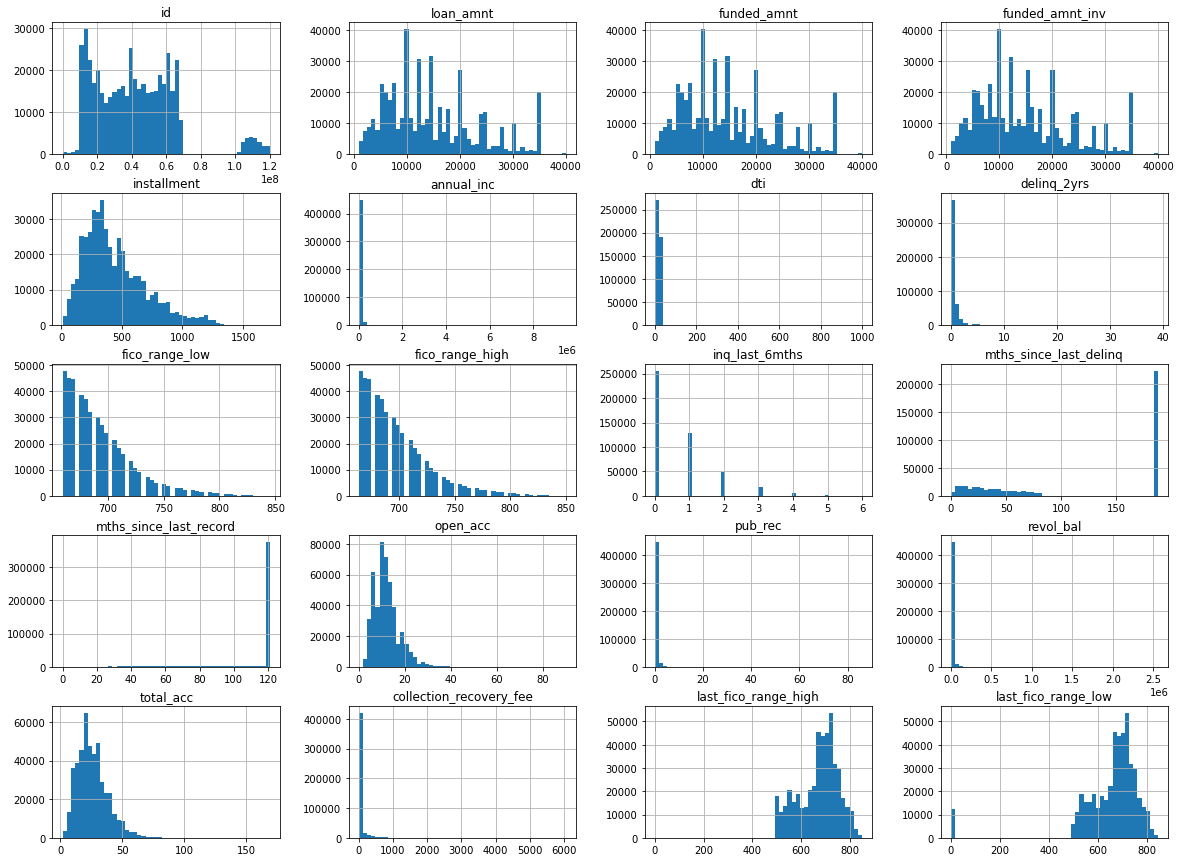

In [39]:
numeric.iloc[:,0:20].hist(bins=50, figsize=(20,15))
plt.show()

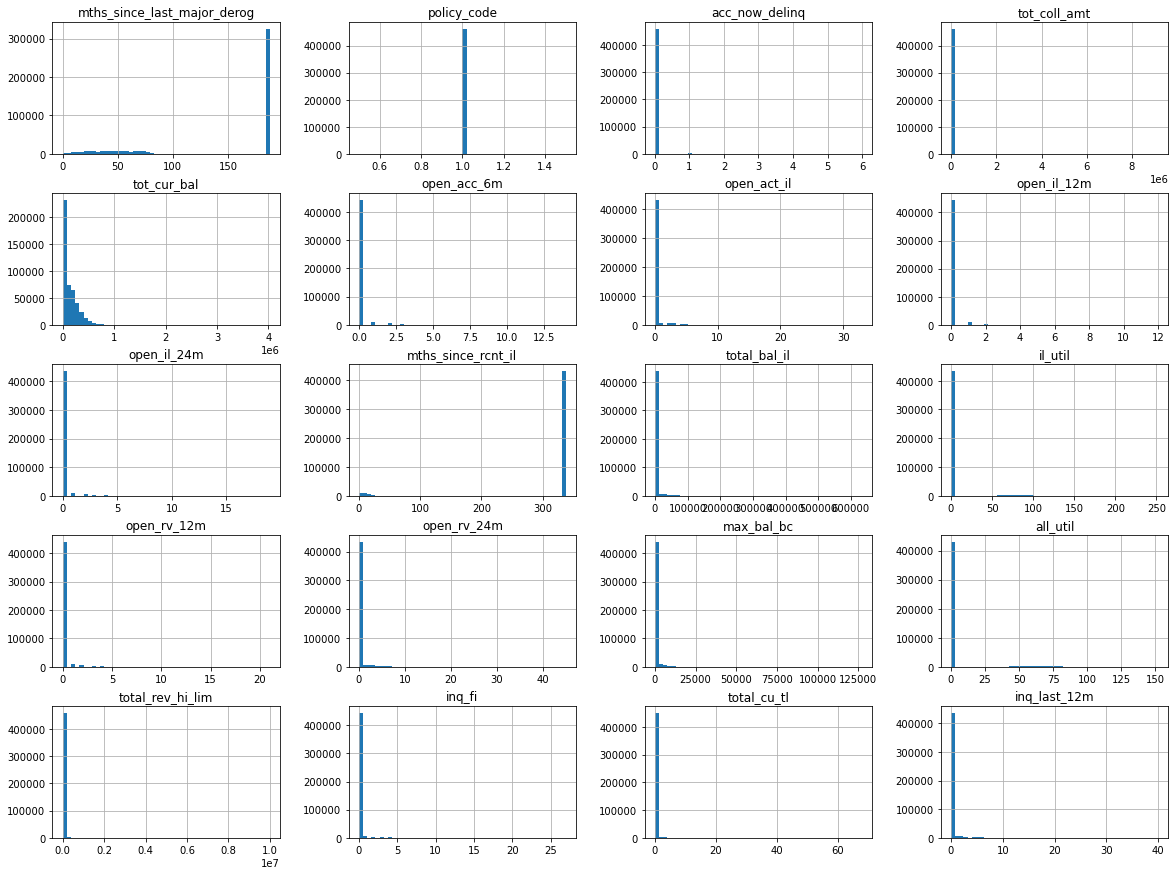

In [40]:
numeric.iloc[:,21:41].hist(bins=50, figsize=(20,15))
plt.show()

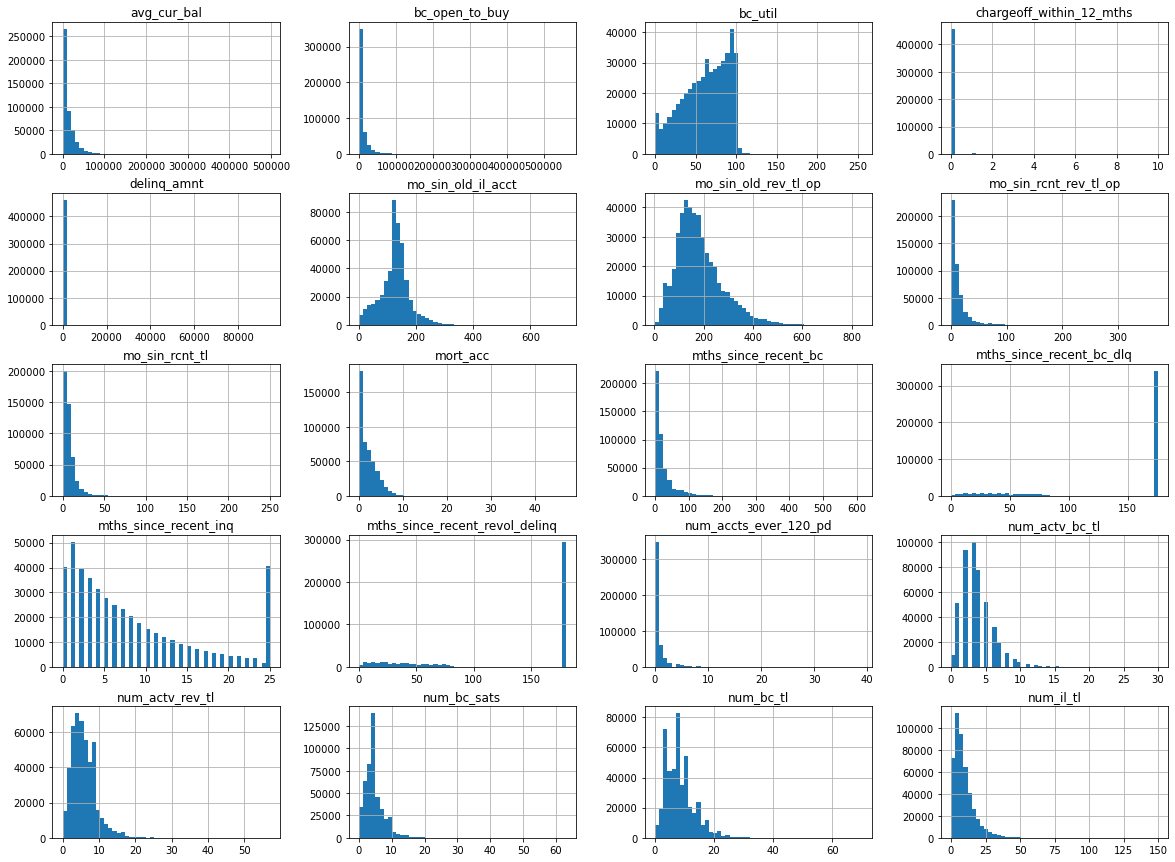

In [41]:
numeric.iloc[:,42:62].hist(bins=50, figsize=(20,15))
plt.show()

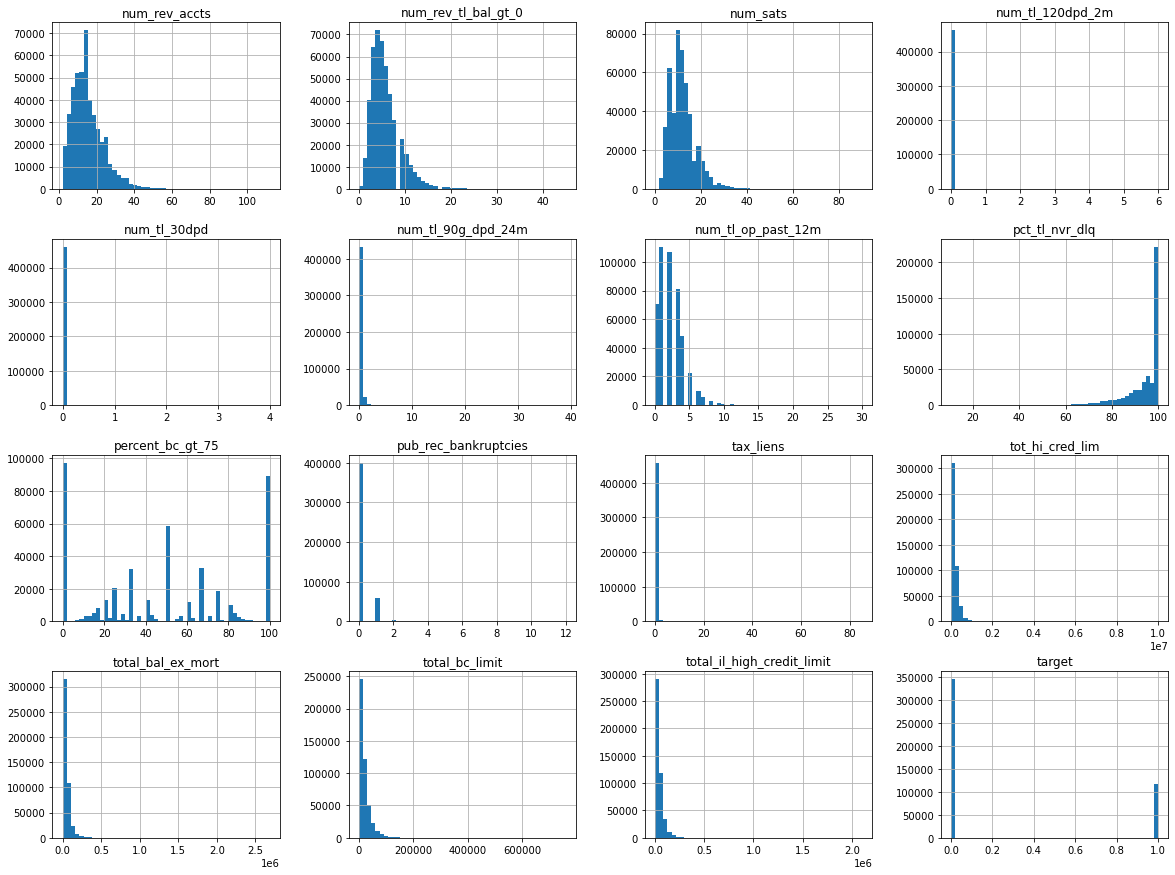

In [42]:
numeric.iloc[:,63:].hist(bins=50, figsize=(20,15))
plt.show()

#### Normalización de las variables numéricas

Normalizamos las variables numércias para poder trabajar con ellas posteriormente

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(numeric), columns = numeric.columns)
num_scaled.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
0,0.932703,0.271154,0.271154,0.273018,0.202395,0.016105,0.017007,0.000000,0.324324,0.322581,...,0.066667,0.951955,0.111,0.083333,0.0,0.052817,0.037511,0.036974,0.057363,0.0
1,0.933626,0.158974,0.158974,0.161125,0.159272,0.005263,0.006076,0.000000,0.135135,0.134409,...,0.000000,0.776536,1.000,0.000000,0.0,0.000760,0.002078,0.004737,0.001903,0.0
2,0.932820,0.166667,0.166667,0.168798,0.128255,0.011579,0.013133,0.000000,0.270270,0.268817,...,0.100000,1.000000,0.083,0.000000,0.0,0.035062,0.017091,0.110132,0.015338,0.0
3,0.932378,0.230769,0.230769,0.232737,0.134410,0.005471,0.010120,0.000000,0.162162,0.161290,...,0.100000,1.000000,0.000,0.166667,0.0,0.003420,0.004074,0.024737,0.002617,0.0
4,0.930789,0.333333,0.333333,0.335038,0.280411,0.007895,0.010871,0.025641,0.135135,0.134409,...,0.100000,0.888268,1.000,0.000000,0.0,0.017059,0.010296,0.003947,0.014425,0.0


## Variables Categóricas

Para poder trabajar con variables categóricas realizaremos posteriormente "one-hot encoding". Sin embargo, hay múltiples ajustes que debemos hacer previamente.

En primer lugar estudiamos las variables categóricas: el dataset categoric contiene 17 columnas y cada variable contiene el siguiente número de grupos o clases.

In [45]:
categoric.shape

(462191, 17)

In [46]:
categoric.nunique() # Count distinct observations over requested axis.

term                        2
int_rate                  200
grade                       7
sub_grade                  35
emp_length                 11
home_ownership              4
verification_status         3
url                    462191
purpose                    14
title                    1944
zip_code                  911
addr_state                 51
earliest_cr_line          689
revol_util               1215
initial_list_status         2
application_type            2
disbursement_method         2
dtype: int64

#### Sustitución de los valores nulos por la moda

Antes de realizar ningún ajuste debemos sustituir los valores nulos por la moda al tratarse de variables categóricas. Las variables que tienen valores nulos son las siguientes

In [47]:
percentage_NaN = categoric.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(5)

emp_length             0.054276
revol_util             0.000506
title                  0.000136
disbursement_method    0.000000
verification_status    0.000000
dtype: float64

In [48]:
# Sustituimos por la moda
categoric = categoric.apply(lambda x: x.replace("", np.nan))
categoric = categoric.apply(lambda x: x.fillna(x.value_counts().index[0])) # fill with the mode

#### Variables que no se pueden utilizar para predecir el impago

Por motivos legales, hay algunos datos de los prestatrios que no se pueden utilizar para predecir el impago, como es el caso de la varibale "zip_code" y "addr_state. Adicionalmente, también eliminamos las variables 'url' y 'title', puesto que no tienen relación con el impago

In [49]:
del categoric['url']
del categoric['title']
del categoric['zip_code']
del categoric['addr_state']

#### Variables con excesivo número de clases

Las variables 'sub_grade' y 'earliest_cr_line' poseen 35 y 689 clases respectivamente, por lo que trabajar con ellas no sería eficiente. Por lo tanto, procedemos a eliminarlas:

In [50]:
del categoric['sub_grade']
del categoric['earliest_cr_line']

#### Variables con clases desbalanceadas

Tras analizar las variables, hemos visto que la variable "disbursement_method" tiene solamente 16 observaciones de la clase "DirectPay" frente a 462175 de "Cash". Es por ello, que consideramos que dicha variable no será relevante y la eliminamos

In [51]:
categoric['disbursement_method'].value_counts()

Cash         462175
DirectPay        16
Name: disbursement_method, dtype: int64

In [52]:
del categoric['disbursement_method']

#### Variables categóricas erróneas

Al estudiar las variables del dataset categoric, observamos que se ha incluido las variables 'int_rate' y 'revol_util' de manera errónea en el dataset ya que se trata de variables numéricas. Procedemos a convertir los porcentajes en variables numéricas.

In [53]:
# Convertimos a strig
int_rate_conversion = categoric['int_rate']
int_rate_conversion = int_rate_conversion.astype(str) 

In [54]:
# Vemos cómo es
int_rate_conversion.head(3)

8       7.35%
10     24.85%
24      7.35%
Name: int_rate, dtype: object

In [55]:
# Eliminamos el símbolo %
int_rate_conversion = int_rate_conversion.map(lambda x: x[:-1])

In [56]:
int_rate_conversion.head(3)

8       7.35
10     24.85
24      7.35
Name: int_rate, dtype: object

In [57]:
# Convertimos a decimal dividiendo entre 100
int_rate_conversion= int_rate_conversion.astype(float)/100
int_rate_conversion.head()

8     0.0735
10    0.2485
24    0.0735
42    0.1602
91    0.1602
Name: int_rate, dtype: float64

In [58]:
# Introducimos en el dataset y eliminamos el objeto creado int_rate_conversion
categoric['int_rate'] = int_rate_conversion 
del int_rate_conversion

In [59]:
categoric.head(3)

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util,initial_list_status,application_type
8,36 months,0.0735,A,6 years,OWN,Not Verified,credit_card,22.7%,w,Individual
10,36 months,0.2485,E,2 years,RENT,Source Verified,debt_consolidation,98.9%,w,Individual
24,36 months,0.0735,A,7 years,MORTGAGE,Not Verified,debt_consolidation,27.2%,w,Individual


Realizamos el mismo procedimiento para la variable "revol_util"

In [60]:
# Convertimos a string
revol_util_conversion = categoric['revol_util']
revol_util_conversion = revol_util_conversion.astype(str)

In [61]:
# Eliminamos el %
revol_util_conversion = revol_util_conversion.map(lambda x: x[:-1])

In [62]:
# VEMOS LOS NAS
percentage_NaN = categoric.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(40)

application_type       0.0
initial_list_status    0.0
revol_util             0.0
purpose                0.0
verification_status    0.0
home_ownership         0.0
emp_length             0.0
grade                  0.0
int_rate               0.0
term                   0.0
dtype: float64

In [63]:
# Convertimos en decimal
revol_util_conversion= revol_util_conversion.astype(float)/100
revol_util_conversion.head()

8     0.227
10    0.989
24    0.272
42    0.200
91    0.900
Name: revol_util, dtype: float64

In [64]:
# Introducimos en el dataset y eliminamos el objeto creado revol_util_conversion
categoric['revol_util'] = revol_util_conversion 
del revol_util_conversion

In [65]:
# Comprobamos que se hayan realizado los cambios
categoric.head(3)

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util,initial_list_status,application_type
8,36 months,0.0735,A,6 years,OWN,Not Verified,credit_card,0.227,w,Individual
10,36 months,0.2485,E,2 years,RENT,Source Verified,debt_consolidation,0.989,w,Individual
24,36 months,0.0735,A,7 years,MORTGAGE,Not Verified,debt_consolidation,0.272,w,Individual


#### Reducción del número de categorías

Algunas variables que hemos considerado relevantes tienen un número de clases muy alto y para poder trabajar con ellas hemos decidido reducir su m¡número de clases siguiendo distintos criterios

La variable emp_length, que recoge el tiempo que cada usuario ha estado empleado, tiene 11 categorías. Sin embargo hemos decidido agruparlas en aquellos que han trabajado durante menos de 5 años, los que han trabajado entre 5 y 10 años, y aquellos que han trabajado durante más de 10 años.

In [66]:
# Vemos el número de observaciones que hay en cada categoría
categoric['emp_length'].value_counts()

10+ years    177520
2 years       41335
< 1 year      37558
3 years       36662
1 year        30006
4 years       27057
5 years       26907
8 years       23176
7 years       22648
6 years       20919
9 years       18403
Name: emp_length, dtype: int64

Definimos la función que reduce las 11 categorías en tres ('< 5 years', '5-10 years' y '> 10 years') y visualizamos el resultado

In [67]:
def f_emp_length(x):
    if x == '< 1 year':
        return '< 5 years'
    elif x == '1 year':
        return '< 5 years'
    elif x == '2 years':
        return '< 5 years'
    elif x == '3 years':
        return '< 5 years'
    elif x == '5 years':
        return '5-10 years'
    elif x == '6 years':
        return '5-10 years'
    elif x == '7 years':
        return '5-10 years'
    elif x == '8 years':
        return '5-10 years'
    elif x == '9 years':
        return '5-10 years'
    else:
        return '> 10 years'
    
categoric.emp_length = categoric.emp_length.map(f_emp_length)
categoric.head()

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util,initial_list_status,application_type
8,36 months,0.0735,A,5-10 years,OWN,Not Verified,credit_card,0.227,w,Individual
10,36 months,0.2485,E,< 5 years,RENT,Source Verified,debt_consolidation,0.989,w,Individual
24,36 months,0.0735,A,5-10 years,MORTGAGE,Not Verified,debt_consolidation,0.272,w,Individual
42,60 months,0.1602,C,5-10 years,RENT,Source Verified,debt_consolidation,0.200,w,Individual
91,36 months,0.1602,C,5-10 years,MORTGAGE,Verified,debt_consolidation,0.900,w,Individual


In [68]:
# Comprobamos que solo hay 3 categorías
categoric.emp_length.value_counts()

> 10 years    204577
< 5 years     145561
5-10 years    112053
Name: emp_length, dtype: int64

<AxesSubplot:>

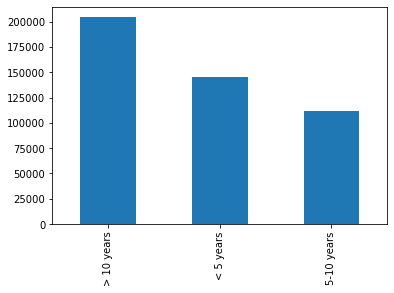

In [69]:
# De manera gráfica se verían de la siguiente manera
graph = categoric['emp_length'].value_counts()
graph.plot(kind = 'bar')

Tenemos el mismo problema con la variable 'purpose', ya que tiene 14 grupos y procederemos a reducirlos en 6. Se agruparan de la siguiente manera:
 - 'debt_consolidation'.
 - 'credit_card'
 - 'housing': which will include 'home_improvement', 'house' and 'moving'.
 - 'leisure': includes 'major_purchase', 'vacation', 'car','wedding','small_business' and 'renewable_energy'.
 - 'medical': 'medical'.
 - 'other': includes 'other' and 'educational'.

In [70]:
# Vemos las categorías iniciales
categoric['purpose'].value_counts()

debt_consolidation    280277
credit_card           103249
home_improvement       27584
other                  22119
major_purchase          8243
medical                 4771
small_business          4279
car                     3895
moving                  2972
vacation                2716
house                   1798
renewable_energy         276
wedding                   11
educational                1
Name: purpose, dtype: int64

In [71]:
# creamos la categoría housing
categoric['purpose'] = np.where ((categoric['purpose'] == 'home_improvement') | 
                            (categoric['purpose'] == 'house') | 
                            (categoric['purpose'] == 'moving'), 
                           'housing', categoric['purpose'].values)

In [72]:
# creamos la categoría leisure
categoric['purpose'] = np.where ((categoric['purpose'] == 'major_purchase') | 
                            (categoric['purpose'] == 'vacation') | 
                            (categoric['purpose'] == 'wedding') |
                            (categoric['purpose'] == 'car')|
                            (categoric['purpose'] == 'small_business') | 
                            (categoric['purpose'] == 'renewable_energy'), 
                           'leisure', categoric['purpose'].values)

In [73]:
# creamos la categoría otros
categoric['purpose'] = np.where ((categoric['purpose'] == 'other') | 
                            (categoric['purpose'] == 'educational'), 
                           'other', categoric['purpose'].values)

In [74]:
# Comprobamos que se han realizado los cambios
categoric['purpose'].value_counts()

debt_consolidation    280277
credit_card           103249
housing                32354
other                  22120
leisure                19420
medical                 4771
Name: purpose, dtype: int64

In [75]:
categoric.head(5)

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util,initial_list_status,application_type
8,36 months,0.0735,A,5-10 years,OWN,Not Verified,credit_card,0.227,w,Individual
10,36 months,0.2485,E,< 5 years,RENT,Source Verified,debt_consolidation,0.989,w,Individual
24,36 months,0.0735,A,5-10 years,MORTGAGE,Not Verified,debt_consolidation,0.272,w,Individual
42,60 months,0.1602,C,5-10 years,RENT,Source Verified,debt_consolidation,0.200,w,Individual
91,36 months,0.1602,C,5-10 years,MORTGAGE,Verified,debt_consolidation,0.900,w,Individual


#### Edición de la variable "grade"

La variable grade hace referencia al sistema de clasificación de la calidad del endeudado, en base a su historial de créditos y la probabilidad de impago.

Los valores que toma son los siguientes:

In [76]:
categoric.grade.unique()

array(['A', 'E', 'C', 'G', 'D', 'B', 'F'], dtype=object)

A es la mejor nota, y por tanto, menos posibilida de impago y G la peor nota con mayor posibilidad de impago. Por ello, daremos valor 6 a aquellos con una A y un 0 a aquellos con una G.

In [77]:
# Creamos un diccionario para cada letra:
dic =  {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0} 

# Sustituimos en cada caso su valor del diccionario:

categoric['grade'] = categoric['grade'].replace(dic)

# Comprobamos el la transformación a numérico:

categoric.grade.unique()

array([6, 2, 4, 0, 3, 5, 1], dtype=int64)

#### Estudio de la relevancia de los grupos

Para seguir analizando si las variables categóricas son relevantes o no para predecir el impago tenemos que volver a juntar las categóricas con las numéricas, ya que la variable target se encuentra en el dataframe de numéricas.

In [78]:
data = pd.concat([numeric, categoric], axis = 1)

In [79]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util,initial_list_status,application_type
8,112038251,11575,11575,11575.0,359.26,153000.0,16.99,0,720,724,...,36 months,0.0735,6,5-10 years,OWN,Not Verified,credit_card,0.227,w,Individual
10,112149045,7200,7200,7200.0,285.70,50000.0,6.07,0,685,689,...,36 months,0.2485,2,< 5 years,RENT,Source Verified,debt_consolidation,0.989,w,Individual
24,112052261,7500,7500,7500.0,232.79,110000.0,13.12,0,710,714,...,36 months,0.0735,6,5-10 years,MORTGAGE,Not Verified,debt_consolidation,0.272,w,Individual
42,111999259,10000,10000,10000.0,243.29,51979.0,10.11,0,690,694,...,60 months,0.1602,4,5-10 years,RENT,Source Verified,debt_consolidation,0.200,w,Individual
91,111808508,14000,14000,14000.0,492.34,75000.0,10.86,1,685,689,...,36 months,0.1602,4,5-10 years,MORTGAGE,Verified,debt_consolidation,0.900,w,Individual


A continuación estudiamos la relevancia de la variable initial_list_status

In [80]:
data.groupby('initial_list_status')['target'].value_counts()

initial_list_status  target
f                    0         150209
                     1          50164
w                    0         195311
                     1          66507
Name: target, dtype: int64

A continuación se muestra que el porcentaje de impago es en ambos casos del 25% por lo que, no sería relevante para predecir el impago y se puede eliminar.

In [81]:
50164/(50164+150209)

0.2503530914843816

In [82]:
66507/(195311+66507)

0.2540199680694223

In [83]:
del data['initial_list_status']

### Gráficos de Frecuencias.

Antes de realizar los gráficos creamos un nuevo dataframe con las variables de tipo objeto:

In [84]:
categoric = data.select_dtypes(include = [np.object])
categoric.head()

,term,emp_length,home_ownership,verification_status,purpose,application_type
8,36 months,5-10 years,OWN,Not Verified,credit_card,Individual
10,36 months,< 5 years,RENT,Source Verified,debt_consolidation,Individual
24,36 months,5-10 years,MORTGAGE,Not Verified,debt_consolidation,Individual
42,60 months,5-10 years,RENT,Source Verified,debt_consolidation,Individual
91,36 months,5-10 years,MORTGAGE,Verified,debt_consolidation,Individual


A continuación mostramos los gráficos de frecuencias de las variables categóricas

<AxesSubplot:>

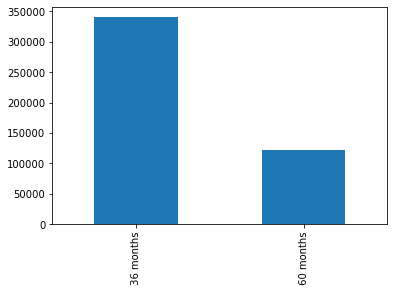

In [85]:
graph = categoric['term'].value_counts()
graph.plot(kind = 'bar')

<AxesSubplot:>

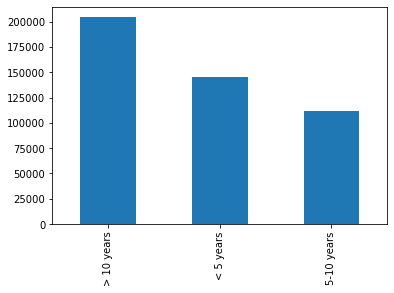

In [86]:
graph = categoric['emp_length'].value_counts()
graph.plot(kind = 'bar')

<AxesSubplot:>

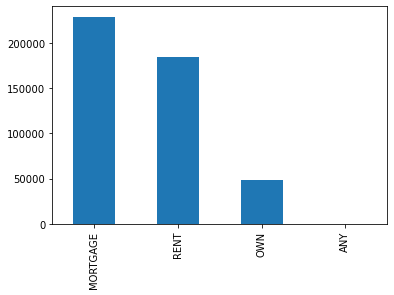

In [87]:
graph = categoric['home_ownership'].value_counts()
graph.plot(kind = 'bar')

<AxesSubplot:>

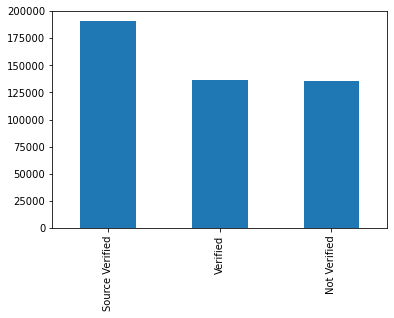

In [88]:
graph = categoric['verification_status'].value_counts()
graph.plot(kind = 'bar')

<AxesSubplot:>

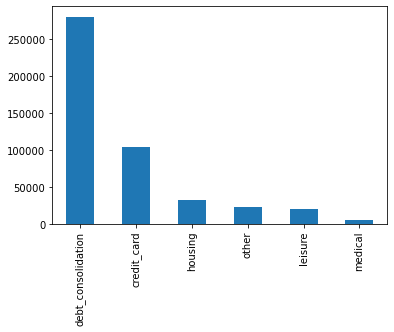

In [89]:
graph = categoric['purpose'].value_counts()
graph.plot(kind = 'bar')

<AxesSubplot:>

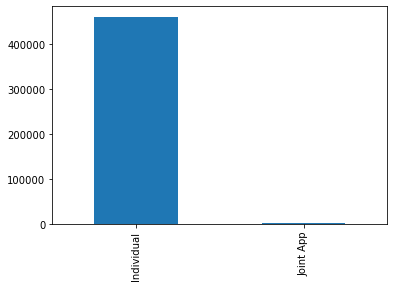

In [90]:
graph = categoric['application_type'].value_counts()
graph.plot(kind = 'bar')

### Creación de variables dummies

In [91]:
# Realizamos el one-hot encoding
dummies = pd.get_dummies(categoric)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462191 entries, 8 to 884875
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   term_ 36 months                      462191 non-null  uint8
 1   term_ 60 months                      462191 non-null  uint8
 2   emp_length_5-10 years                462191 non-null  uint8
 3   emp_length_< 5 years                 462191 non-null  uint8
 4   emp_length_> 10 years                462191 non-null  uint8
 5   home_ownership_ANY                   462191 non-null  uint8
 6   home_ownership_MORTGAGE              462191 non-null  uint8
 7   home_ownership_OWN                   462191 non-null  uint8
 8   home_ownership_RENT                  462191 non-null  uint8
 9   verification_status_Not Verified     462191 non-null  uint8
 10  verification_status_Source Verified  462191 non-null  uint8
 11  verification_status_Verified         46

In [92]:
dummies.head()

,term_ 36 months,term_ 60 months,emp_length_5-10 years,emp_length_< 5 years,emp_length_> 10 years,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_housing,purpose_leisure,purpose_medical,purpose_other,application_type_Individual,application_type_Joint App
8,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
10,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
24,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
42,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
91,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


Eliminamos las variables de tipo objeto del dataset original para posteriormente imputar las variables dummies.

In [93]:
del data['term']
del data['emp_length']
del data['home_ownership']
del data['verification_status']
del data['purpose']
del data['application_type']

Juntamos el el dataframe con las variables categóricas convertidas a dummies con el dataframe original y llamamos a este nuevo dataframe data_filter.

In [94]:
data_filter = pd.merge(numeric, dummies, left_index=True, right_index=True)
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462191 entries, 8 to 884875
Data columns (total 99 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   462191 non-null  int64  
 1   loan_amnt                            462191 non-null  int64  
 2   funded_amnt                          462191 non-null  int64  
 3   funded_amnt_inv                      462191 non-null  float64
 4   installment                          462191 non-null  float64
 5   annual_inc                           462191 non-null  float64
 6   dti                                  462191 non-null  float64
 7   delinq_2yrs                          462191 non-null  int64  
 8   fico_range_low                       462191 non-null  int64  
 9   fico_range_high                      462191 non-null  int64  
 10  inq_last_6mths                       462191 non-null  int64  
 11  mths_since_la

In [95]:
data_filter.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_housing,purpose_leisure,purpose_medical,purpose_other,application_type_Individual,application_type_Joint App
8,112038251,11575,11575,11575.0,359.26,153000.0,16.99,0,720,724,...,0,0,1,0,0,0,0,0,1,0
10,112149045,7200,7200,7200.0,285.70,50000.0,6.07,0,685,689,...,1,0,0,1,0,0,0,0,1,0
24,112052261,7500,7500,7500.0,232.79,110000.0,13.12,0,710,714,...,0,0,0,1,0,0,0,0,1,0
42,111999259,10000,10000,10000.0,243.29,51979.0,10.11,0,690,694,...,1,0,0,1,0,0,0,0,1,0
91,111808508,14000,14000,14000.0,492.34,75000.0,10.86,1,685,689,...,0,1,0,1,0,0,0,0,1,0


En total tenemos 462,191 filas y 99 columnas

In [96]:
data_filter.shape

(462191, 99)

Comprobamos que no hay valores nulos

In [97]:
percentage_NaN_data_filter = data_filter.apply(lambda x: sum(x.isna()/len(data)))
percentage_NaN.sort_values(ascending = False).head(40)

application_type       0.0
initial_list_status    0.0
revol_util             0.0
purpose                0.0
verification_status    0.0
home_ownership         0.0
emp_length             0.0
grade                  0.0
int_rate               0.0
term                   0.0
dtype: float64

Exportamos el nuevo dataframe como csv

In [103]:
ruta = '../data/02_intermediate/data_cleaned.csv'

In [104]:
data_filter.to_csv(ruta)